# Read data

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns

In [40]:
# replace this with the file path on your computer
df = pd.read_csv('/content/drive/MyDrive/Projects/FirePrediction/data.csv', index_col=0)

In [68]:
# train-test-split before I preform anything
from sklearn.model_selection import train_test_split
X = df.drop(columns='STAT_CAUSE_DESCR')
y = df['STAT_CAUSE_DESCR']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Null columns

2024.04.23
We will drop all columns that contains null

In [11]:
column_stats = []
for column_name in df.columns:
    column = df[column_name]
    num_null = column.isnull().sum()
    total_values = len(column)
    null_percent = (num_null / total_values) * 100
    num_of_unique_values = len(column.unique())
    column_stats.append((column_name, num_null, null_percent,num_of_unique_values))

column_stats_df = pd.DataFrame(column_stats, columns=['ColumnName', 'NullNumber', 'NullPercentage', "UniqueValueNumber"])
column_stats_df

,ColumnName,NullNumber,NullPercentage,UniqueValueNumber
0,OBJECTID,0,0.000000,571425
1,FOD_ID,0,0.000000,571425
2,FPA_ID,0,0.000000,571425
3,SOURCE_SYSTEM_TYPE,0,0.000000,3
4,SOURCE_SYSTEM,0,0.000000,32
5,NWCG_REPORTING_AGENCY,0,0.000000,10
6,NWCG_REPORTING_UNIT_ID,0,0.000000,1345
7,NWCG_REPORTING_UNIT_NAME,0,0.000000,1341
8,SOURCE_REPORTING_UNIT,0,0.000000,4124
9,SOURCE_REPORTING_UNIT_NAME,0,0.000000,3611


# Catagorical - Cross Entropy

## High Cardinality catagories

In [69]:
# These are High cardinality catagorical features
HC_features = ['NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME',
               'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME']

In [70]:
#  generic function for frequency encoding
from sklearn.preprocessing import LabelEncoder
frequency_encoder_map = {}
def train_frequency_encoders(df, feature):
  frequency_encoder = df[feature].value_counts(normalize=True)
  frequency_encoder_map[feature] = frequency_encoder
  return df

def frequency_encoding(df, feature):
  le = frequency_encoder_map[feature]
  df['FE-'+ feature] = df[feature].map(frequency_encoder_map[feature])
  return df

In [71]:
# train the frequency encoders
for feature in HC_features:
  X_train = train_frequency_encoders(X_train, feature)

We can see that for some features, if the feature equals certain value f1, the distribution of the labels in the target column will change largely. We will use the tool cross entropy to encode the columns. H(D|feature=f1)

# Training


In [72]:
# Generic function that will transform the data into format of XGBoost
from sklearn.preprocessing import LabelEncoder
target_encoder = LabelEncoder()
# initialize target encoder for y to maintain consistency
target_encoder.fit(y)
def transform_y_for_XGB(y):
  return target_encoder.transform(y)

# select features for trainin: This list depends on feature engineering
frequency_encoding_features = ['FE-NWCG_REPORTING_UNIT_ID', 'FE-NWCG_REPORTING_UNIT_NAME',
                                'FE-SOURCE_REPORTING_UNIT', 'FE-SOURCE_REPORTING_UNIT_NAME']
selected_features = frequency_encoding_features

def transform_X_for_XGB(X):
  # frequency encoding
  for feature in HC_features:
    X = frequency_encoding(X, feature)

  # select feature for training
  X = X[selected_features]
  catagorial_columns = X.select_dtypes('object').columns.tolist()
  for col in catagorial_columns:
    X = X.astype({col:'category'})
  return X

# putting everything together so that it's easier
def transform_data_for_XGB(X, y):
  return transform_X_for_XGB(X), transform_y_for_XGB(y)

In [73]:
X_train, y_train = transform_data_for_XGB(X_train, y_train)
X_val, y_val = transform_data_for_XGB(X_val, y_val)

In [74]:
from xgboost import XGBClassifier
# define hyper parameters
params = {
    # "tree_method": "hist",
    "device": "cuda",
    "enable_categorical": True,
    # "eval_metric": auc_ovr,
    #  "n_estimators": 85,
    # "max_cat_to_onehot": 4
    # "colsample_bylevel": 0.7,
    # 'objective':'multi:softmax',  # for multi-class classification
}
# create model instance
clf = XGBClassifier(**params,)
# fit model
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:39:24] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.15234	validation_1-mlogloss:2.15461
[1]	validation_0-mlogloss:1.99933	validation_1-mlogloss:2.00242
[2]	validation_0-mlogloss:1.90242	validation_1-mlogloss:1.90604
[3]	validation_0-mlogloss:1.83318	validation_1-mlogloss:1.83731
[4]	validation_0-mlogloss:1.78196	validation_1-mlogloss:1.78612
[5]	validation_0-mlogloss:1.74252	validation_1-mlogloss:1.74667
[6]	validation_0-mlogloss:1.71210	validation_1-mlogloss:1.71635
[7]	validation_0-mlogloss:1.68930	validation_1-mlogloss:1.69365
[8]	validation_0-mlogloss:1.67023	validation_1-mlogloss:1.67450
[9]	validation_0-mlogloss:1.65395	validation_1-mlogloss:1.65823
[10]	validation_0-mlogloss:1.64086	validation_1-mlogloss:1.64539
[11]	validation_0-mlogloss:1.63018	validation_1-mlogloss:1.63492
[12]	validation_0-mlogloss:1.62106	validation_1-mlogloss:1.62601
[13]	validation_0-mlogloss:1.61328	validation_1-mlogloss:1.61830
[14]	validation_0-mlogloss:1.60585	validation_1-mlogloss:1.61096
[15]	validation_0-mlogloss:1.59857	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Evaluation

In [80]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function that will print the preformance for each class
def plot_auc_by_class(y_val, y_pred_prob):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  label_binarizer = LabelBinarizer()

  for i in range(y_pred_prob.shape[1]):
    y_true_class = label_binarizer.fit_transform(y_val == i)
    # Calculate ROC curve and AUC for the current class
    fpr[i], tpr[i], _ = roc_curve(y_true_class[:, 0], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  # Plot ROC curves for each class
  plt.figure(figsize=(10, 8))

  for i in range(y_pred_prob.shape[1]):
      class_name = target_encoder.inverse_transform([i])[0]
      plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
  plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot diagonal line for reference
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for Each Class')
  plt.legend(loc='lower right')
  plt.show()

In [76]:
from sklearn.metrics import roc_auc_score
y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
ovr_auc

0.8015150262654044

In [79]:
y_val

array([1, 3, 0, ..., 3, 4, 3])

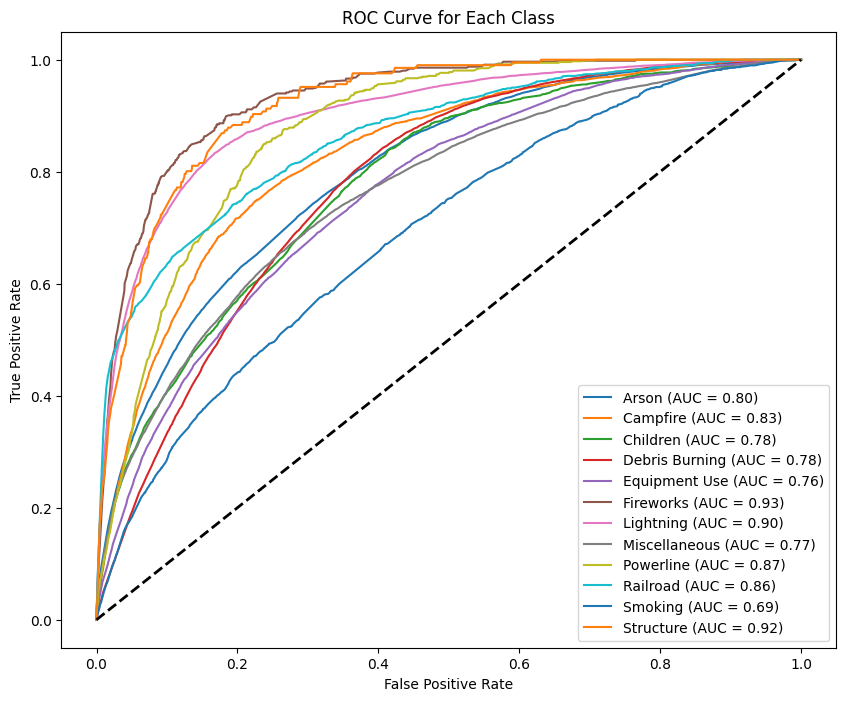

In [81]:
plot_auc_by_class(y_val, y_pred_prob)